# One-class SVM
One-class SVM is a Support Vector Machine used for unsupervised learning, it is called One-class as it will classify the data into a single classification cluster, thereby finding any outliers/anomalies by the data points not covered within the single classification cluster (also referred to as novelty detection).

## Sources used
[What is One-Class SVM ? How to use it for anomaly detection?](https://machinelearninginterview.com/topics/machine-learning/what-is-one-class-svm-how-to-use-it-for-anomaly-detection/)

### Inspecting the data
One-class SVM, as a form of Support Vector machine, utilizes the differences between features to classify the data points. This can be represented for example in a scatter plot by the distance between different points.

For this project, we want to find malicious network requests from networking logs, thereby having the benign data be classified and the malicious data become outliers.

As a prerequisite to this data inspection, it is highly recommended to view the EDA notebook done for this project (this can be found in the [sueAI repository](https://github.com/Fowthy/SueAI))

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/elastic_february2022_data.csv')

Lets take a quick look at the general data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398414 entries, 0 to 398413
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   _source_flow_id            398414 non-null  object 
 1   _source_flow_final         398414 non-null  bool   
 2   _source_source_ip          398414 non-null  object 
 3   _source_destination_ip     398414 non-null  object 
 4   _source_network_bytes      398414 non-null  int64  
 5   _source_network_transport  396080 non-null  object 
 6   _source_@timestamp         398414 non-null  object 
 7   _source_event_duration     398414 non-null  int64  
 8   _source_destination_port   395857 non-null  float64
 9   _source_source_port        395857 non-null  float64
 10  label                      398414 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 30.8+ MB


In [5]:
df.head(5)

,_source_flow_id,_source_flow_final,_source_source_ip,_source_destination_ip,_source_network_bytes,_source_network_transport,_source_@timestamp,_source_event_duration,_source_destination_port,_source_source_port,label
0,EAD/////AP////////8AAAGsEAILrBACDA,False,240.16.203.232,240.16.203.236,72096053,NaN,2022-02-25T12:20:00.007Z,41753051589,NaN,NaN,benign
1,EAD/////AP////////8AAAGsEAIKrBACDA,False,240.16.203.236,240.16.203.233,913734,NaN,2022-02-25T12:20:00.007Z,35268442180,NaN,NaN,benign
2,EAT/////AP//////CP8AAAHAqFSDwKj3AAEIbQI,False,190.215.171.30,190.215.9.27,30684984,tcp,2022-02-25T12:20:00.007Z,41662926223,621.0,2049.0,benign
3,EAT/////AP//////CP8AAAHAqFSPwKj3D8CeVCQ,False,190.215.171.17,190.215.9.16,220136,tcp,2022-02-25T12:20:00.007Z,41154340691,9300.0,40640.0,benign
4,EAT/////AP//////CP8AAAEKapNUwKj3DvAjvpo,False,190.215.9.17,53.181.234.140,73242,tcp,2022-02-25T12:20:00.007Z,41259502779,9200.0,39614.0,benign


In [4]:
df.tail(5)


,_source_flow_id,_source_flow_final,_source_source_ip,_source_destination_ip,_source_network_bytes,_source_network_transport,_source_@timestamp,_source_event_duration,_source_destination_port,_source_source_port,label
398409,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,True,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,23101,9099.0,51980.0,benign
398410,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,18591,9099.0,52008.0,benign
398411,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,19850,9099.0,52024.0,benign
398412,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,35017,9099.0,52040.0,benign
398413,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,33292,9099.0,52070.0,benign


To get started, as the One-class SVM will create a single classification with the rest outliers, lets create one hot encoded feature called outlier that will show the malicious points, as the model should show these as outliers.

In [15]:
df['outlier'] = df['label'].apply(lambda x: 1 if x == 'malicious' else 0)

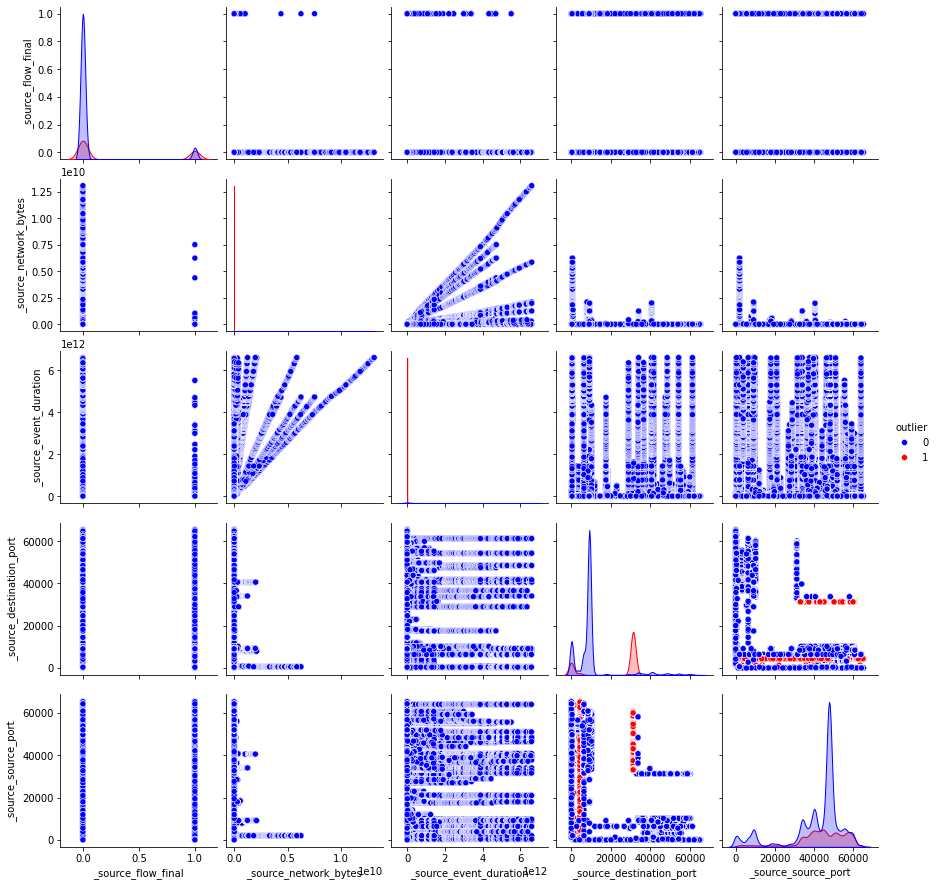

In [21]:
sns.pairplot(df[['_source_flow_final', '_source_network_bytes', '_source_event_duration', '_source_destination_port', '_source_source_port', 'outlier']], diag_kind="kde", hue="outlier", palette={0: "blue", 1: "red"})

Above I have created a pairplot, of the different numerical features plotted against one another, with the benign data in blue and the malicious data in red.  
Diagonally, an estimate is shown of the kernal density, this can give an idea of the distribution of a feature over the range found of all the data points (e.g. if the feature has evenly distributed data points it should look like a normal distribution).

The numerical feature (which isn't really numerical, as it has no relation to the number scale) is the _source_destination_port, this feature records where the networking request went to when communicating with the cluster.  
The _source_destination_port shows a clear jump in occurences somewhere around ~30000 while the benign frequency stays low, which would be perfect for anomaly detection.  
However, it should be kept in mind that this data was collected in an experiment/research setting and all malicious data collected is not only simulated but could also be specific to the experiment environment, as between clusters/deployments or even between different kinds of attacks (this dataset only had a few different kinds of attacks) the destination port could change.

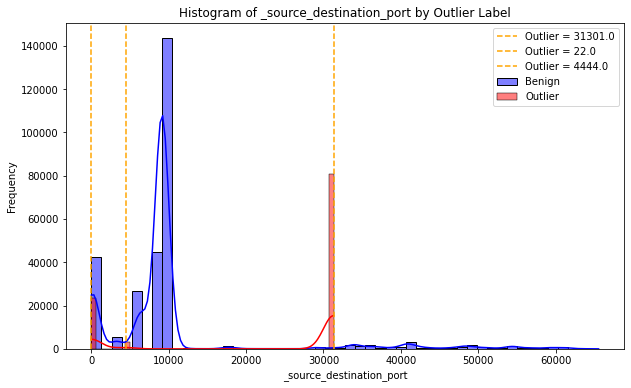

In [35]:
# Filter the data for "outlier" equals 0 and 1
benign_data = df[df['outlier'] == 0]['_source_destination_port']
outlier_data = df[df['outlier'] == 1]['_source_destination_port']

common_bins = 50

# Create the histograms for both categories
plt.figure(figsize=(10, 6))

sns.histplot(benign_data, kde=True, label="Benign", color='blue', bins=common_bins)
sns.histplot(outlier_data, kde=True, label="Outlier", color='red', bins=common_bins)

# Get indicators for places where outliers are noticeably higher than benign
outlier_counts = outlier_data.value_counts()
outlier_ports = outlier_counts[outlier_counts > 1000].index.tolist()
for outlier_port in outlier_ports:
    plt.axvline(outlier_port, color='orange', linestyle='--', label=f"Outlier = {outlier_port}")

plt.title('Histogram of _source_destination_port by Outlier Label')
plt.xlabel('_source_destination_port')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Above is a histogram of the distribution of benign vs outlier data for the _source_destination_port, here three noticeable outliers were found (>1000 requests more of outliers than benign)

### SKLearn OneClassSVM

In [8]:
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Load the dataset again

In [2]:
df = pd.read_csv('../data/elastic_february2022_data.csv')

For this first attempt, only the _source_destination_port feature will be used, as this showed the most promise without doing any further data processing, so this can be a good baseline to start from

To get the feature ready, some null values will have to be removed

In [3]:
df['_source_destination_port'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 398414 entries, 0 to 398413
Series name: _source_destination_port
Non-Null Count   Dtype  
--------------   -----  
395857 non-null  float64
dtypes: float64(1)
memory usage: 3.0 MB


In [4]:
sdp_df = df[['_source_destination_port', 'label']]
sdp_df = sdp_df.dropna()

First lets split the data into the X features, and the Y predictor

In [5]:
X = sdp_df['_source_destination_port'].values.reshape(-1, 1)
y = sdp_df['label']

Next, we will split the data into train and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The first One-class SVM that will be tried is SGDOneClassSVM, this utilizes a much faster gradient descent kernel to approcimate similar results to normal OneClassSVM, with the down-side being that it can only use a linear kernel model, but is significantly faster to train as it does not have the downside of the exponential training time growth based on training dataset size that the Gaussian technique of OneClassSVM has.

#### SGD One-class SVM

Now lets compile, train and evaluate the One-class SVM model, by default a nu score of 0.5 will be used

In [40]:
def EvaluateSGDOneClassSVM(nu = 0.5):
    # Compile and train the model
    sgd_sdp_model = SGDOneClassSVM(nu=nu)
    sgd_sdp_model.fit(X_train)
    # Test the model
    sgd_sdp_predictions = sgd_sdp_model.predict(X_test)
    sgd_sdp_predictions = ['benign' if pred == 1 else 'malicious' for pred in sgd_sdp_predictions] # By default, OneClassSVM will give -1 for outliers and 1 for inliers
    # Create a classification report
    return classification_report(y_test, sgd_sdp_predictions, target_names=['benign', 'malicious'])


In [42]:
print(EvaluateSGDOneClassSVM())

c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      benign       0.73      1.00      0.84     57523
   malicious       0.00      0.00      0.00     21649

    accuracy                           0.73     79172
   macro avg       0.36      0.50      0.42     79172
weighted avg       0.53      0.73      0.61     79172



c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Something very interesting occured with the model above, the model has created a line that actually did not have any datapoints as outliers, causing everything to be classified as inliers. While this would indicate that the 'nu' hyperparameter might have been too strict on allowing outliers (a low nu value), it does give us some insight on how the model would perform when just guessing everything to be benign as this is the majority of data given anyway.

Now lets try it with a larger nu score and see what happens

In [47]:
print(EvaluateSGDOneClassSVM(0.9))

              precision    recall  f1-score   support

      benign       0.77      1.00      0.87     57523
   malicious       0.98      0.22      0.36     21649

    accuracy                           0.79     79172
   macro avg       0.88      0.61      0.61     79172
weighted avg       0.83      0.79      0.73     79172



Giving the model a very high tolerance for outliers (the range is from 0-1), the model actually seemed to have improved significantly. In the above example, the precision for malicious data is relatively high at 98%, meaning it very rarely classified benign data as malicious.  
But recall, is very low meaning that it did not catch every malicious data point it found.  
Coming back around to the requirements of the stakeholder, this is actually the opposite of what they wanted (excluding the fact they want an overall accuracy of atleast 99.99%) they care more about catching every malicious entry and sometimes giving false positives, then the otherway around. 

Lets do some quick hyperparameter tuning to see if a large difference can be made based on the nu parameter

In [68]:
import warnings

results = []

# Iterate through parameter values from 0.05 to 0.95 with 0.05 increments
for nu in [i/20 for i in range(1, 20)]:
    # Hide the warnings of the evaluation report, as there will be many attempts where no outliers are found
    warnings.filterwarnings("ignore")
    # Call your evaluation function with the parameter
    report = EvaluateSGDOneClassSVM(nu)
    warnings.filterwarnings("default")
    
    # Extract the precision for class 1 from the results
    recall = float(report.split('\n')[3].split()[2])
    
    # Store the results
    results.append({"nu": nu, "malicious_recall": recall})

In [69]:
results_df = pd.DataFrame(results)
print(results_df)

      nu  malicious_recall
0   0.05              0.00
1   0.10              0.00
2   0.15              0.00
3   0.20              0.00
4   0.25              0.00
5   0.30              0.00
6   0.35              0.00
7   0.40              0.22
8   0.45              0.00
9   0.50              0.00
10  0.55              0.00
11  0.60              0.00
12  0.65              0.00
13  0.70              0.00
14  0.75              0.00
15  0.80              0.00
16  0.85              0.22
17  0.90              0.22
18  0.95              0.00


As shown from this list above, where I went through and cross validated the nu hyperparameter looking for the best malicious recall, it kinda sucks... In fact, there were only 3 times when any malicious entries were found, showing that this model might be fundamentally flawed for this usecase.  
These results however were expected, as this model currently uses a linear line to split the single feature for benign or malicious data, and was done as a very first attempt that could be done to get an understanding of One-class SVM, as other models might take significantly longer to train due to their horrible large dataset performance.

#### RBF One-class SVM

Next up, lets use a more commonly used One-class SVM model with the rbf kernel, which utilizes the distance from origin (0,0) to determine the split of outliers and inliers

In [70]:
sdp_model = OneClassSVM(kernel="rbf")

Now lets train the model

In [71]:
sdp_model.fit(X_train)

OneClassSVM()

Lets evaluate this initial model

In [72]:
sdp_predictions = sdp_model.predict(X_test)
sdp_predictions = ['benign' if pred == 1 else 'malicious' for pred in sdp_predictions] # By default, OneClassSVM will give -1 for outliers and 1 for inliers

In [73]:
print(classification_report(y_test, sdp_predictions, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       0.71      0.71      0.71     57523
   malicious       0.22      0.22      0.22     21649

    accuracy                           0.57     79172
   macro avg       0.46      0.46      0.46     79172
weighted avg       0.57      0.57      0.57     79172



Some things to keep in mind:  
First, the feature used, while a good showcase of the model, does in no way show a good feature to use for this project, as said before the destination port will change depending on the environment and possible attack, making this model good only for this specific dataset, which as a reminder was collected as part of an expirement and thus might not reflect the real world.  

Secondly, the 'nu' hyperparameter can be tuned to determine how tolerant the model should be of allowing outliers, the bigger the number the more tolerent. During intial EDA, it came out that from the dataset used ~25% was Malicious or outliers in this case, that is a significant amount, meaning that larger nu values might perform better currently. But the more regular traffic goes to a cluster, the lower this precentage should become, while it could be possible that 25% of traffic is malicious over a large enough span (as DDOS attacks for example, rely on large amounts of traffic) during normal operations this is often not the case and could cause a large amount of false positives.